# Aula 9 - InPars

[Unicamp - IA368DD: Deep Learning aplicado a sistemas de busca.](https://www.cpg.feec.unicamp.br/cpg/lista/caderno_horario_show.php?id=1779)

Autor: Marcus Vinícius Borela de Castro

[Repositório no github](https://github.com/marcusborela/deep_learning_em_buscas_unicamp)


# Enunciado exercício



Objetivo: gerar dataset para treino de modelos de buscas usando a técnica do InPars e avaliar um modelo reranqueador treinado neste dataset no TREC-COVID:

Entrada: 3-5 exemplos few-shot + documento amostrado da coleção do TREC-COVID

Saída: query que seja relevante para o documento amostrado

É opcional fazer a etapa de filtragem usando as queries de maior prob descrita no Artigo.

Como modelo gerador, use um dos seguintes modelos:
ChatGPT-3.5-turbo: ~1 USD para cada 1k exemplos
FLAN-T5 (base, large ou XL), LLAMA-(7,13B), Alpaca-(7/13B), que são possiveis de rodar no Colab Pro.

Também tem a inference-api da HF: https://huggingface.co/inference-api.

Com exceção do LLAMA, é possivel usar zero-shot ao inves de few-shot.
Dado 1k-10k pares <query sintética; documento>, treinar um modelo reranqueador miniLM igual ao da aula 2/3.

Exemplos negativos (i.e., <query sintética; doc não relevant) vem do BM25: dado a query sintetica, retornar top 1000 com o BM25, e amostrar aleatoriamente alguns documentos como negativo

Começar treino do miniLM já treinado no MS MARCO

Avaliar no TREC-COVID e comparar com o reranqueador apenas treinado no MSMARCO

Nota: Também usar o dataset dos colegas para obter diversidade de exemplos: Assim que tiver gerado o dataset sintético, favor colocar na planilha, assim outras pessoas podem usa-lo.
- Para aumentar a aleatoriedade, seed usada deve o seu numero na planilha.

Colocar dataset no formato jsonlines:
{"query": query, "positive_doc_id": doc_id, "negative_doc_ids": [opcional]}\n 



Dicas: (do exercício da aula 2)

- Siga sempre um padrão ao criar os exemplos few-shot. Aqui tem uma pagina com dicas para prompt engineering: https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api


- Usar a API do LLAMA fornecida por nós (licença exclusiva para pesquisa). [Colab demo da API do LLAMA](https://colab.research.google.com/drive/1zZ-ch29LTicNPA62t2MaOwMROywnqUxf?usp=sharing) (obrigado, Thales Rogério)
- Opcionalmente, usar a API do code-davinci-002, que é de graça e trás resultados muito bons.
CUIDADO: NÃO USAR O TEXT-DAVINCI-002/003, que é pago

- Opcionalmente, usar a API do ChatGPT (gpt-3.5-turbo) que é barata: ~1 centavo de real por 1000 tokens (uma página)
  
- Opcionalmente, usar o Alpaca: https://alpaca-ai.ngrok.io/



Este caderno contempla o passo 5 (finetuning do modelo) do [fluxo de processamento](https://github.com/marcusborela/deep_learning_em_buscas_unicamp/blob/main/presentations/articles/Aula%208%20-%20InPars%20Process.png)

# Organizando o ambiente

## Importações

In [1]:
import requests  # para Llama
import time # para Llama

In [2]:
from tqdm import tqdm

In [ ]:
import io

In [ ]:
import time


In [3]:
import string

In [4]:
import gzip

In [5]:
import getpass

In [6]:
import gc

In [7]:
import json, time

In [8]:
from transformers import BatchEncoding

/home/borela/miniconda3/envs/treinapython39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import torch

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [11]:
from torch.utils.data import DataLoader

In [12]:
from torch.utils.data import Dataset

In [13]:
from psutil import virtual_memory

In [14]:
import pandas as pd
import os

In [15]:
import random
import numpy as np
import torch

In [16]:
import transformers

In [17]:
import datasets

In [18]:
import pickle

In [19]:
from statistics import mean, stdev

## Definindo paths

In [20]:
DIRETORIO_LOCAL = '/home/borela/fontes/deep_learning_em_buscas_unicamp/local'
DIRETORIO_TRABALHO = F'{DIRETORIO_LOCAL}/inpars'
DIRETORIO_TREC_COVID = F'{DIRETORIO_LOCAL}/trec_covid'
DIRETORIO_MSMARCO = F'{DIRETORIO_LOCAL}/msmarco'
DIRETORIO_TREINO = F'{DIRETORIO_TRABALHO}/treino'


In [21]:
if os.path.exists(DIRETORIO_LOCAL):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_LOCAL)
    print('pasta criada!')


pasta já existia!


In [22]:
if os.path.exists(DIRETORIO_TRABALHO):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TRABALHO)
    print('pasta criada!')


pasta já existia!


In [23]:
if os.path.exists(DIRETORIO_TREINO):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TREINO)
    print('pasta criada!')


pasta já existia!


## Função de verificação de memória

In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May  2 22:40:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   46C    P8    36W / 370W |   1306MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
def mostra_memoria(lista_mem=['cpu']):
  """
  Esta função exibe informações de memória da CPU e/ou GPU, conforme parâmetros fornecidos.

  Parâmetros:
  -----------
  lista_mem : list, opcional
      Lista com strings 'cpu' e/ou 'gpu'. 
      'cpu' - exibe informações de memória da CPU.
      'gpu' - exibe informações de memória da GPU (se disponível).
      O valor padrão é ['cpu'].

  Saída:
  -------
  A função não retorna nada, apenas exibe as informações na tela.

  Exemplo de uso:
  ---------------
  Para exibir informações de memória da CPU:
      mostra_memoria(['cpu'])

  Para exibir informações de memória da CPU e GPU:
      mostra_memoria(['cpu', 'gpu'])
  
  Autor: Marcus Vinícius Borela de Castro

  """  
  if 'cpu' in lista_mem:
    vm = virtual_memory()
    ram={}
    ram['total']=round(vm.total / 1e9,2)
    ram['available']=round(virtual_memory().available / 1e9,2)
    # ram['percent']=round(virtual_memory().percent / 1e9,2)
    ram['used']=round(virtual_memory().used / 1e9,2)
    ram['free']=round(virtual_memory().free / 1e9,2)
    ram['active']=round(virtual_memory().active / 1e9,2)
    ram['inactive']=round(virtual_memory().inactive / 1e9,2)
    ram['buffers']=round(virtual_memory().buffers / 1e9,2)
    ram['cached']=round(virtual_memory().cached/1e9 ,2)
    print(f"Your runtime RAM in gb: \n total {ram['total']}\n available {ram['available']}\n used {ram['used']}\n free {ram['free']}\n cached {ram['cached']}\n buffers {ram['buffers']}")
    print('/nGPU')
    gpu_info = !nvidia-smi
  if 'gpu' in lista_mem:
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)


In [26]:
mostra_memoria(['cpu','gpu'])

Your runtime RAM in gb: 
 total 67.35
 available 46.47
 used 19.62
 free 45.49
 cached 2.12
 buffers 0.12
/nGPU
Tue May  2 22:40:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   46C    P8    36W / 370W |   1306MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+

## Definindo Hiperparâmetros iniciais

In [27]:
def inicia_hparam()->dict:
  # Inicialização dos parâmetros
  hparam = {}
  hparam["num_workers_dataloader"] = 0
  hparam["device"] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available(): print(torch. cuda. get_device_name(hparam["device"]))    
  return hparam

In [28]:
hparam=inicia_hparam()

NVIDIA GeForce RTX 3090


## Fixando as seeds

In [29]:
def inicializa_seed(num_semente:int=123):
  """
  Inicializa as sementes para garantir a reprodutibilidade dos resultados do modelo.
  Essa é uma prática recomendada, já que a geração de números aleatórios pode influenciar os resultados do modelo.
  Além disso, a função também configura as sementes da GPU para garantir a reprodutibilidade quando se utiliza aceleração por GPU. 
  
  Args:
      num_semente (int): número da semente a ser utilizada para inicializar as sementes das bibliotecas.
  
  References:
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  # Define as sementes das bibliotecas random, numpy e pytorch
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  
  # Define as sementes da GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True


In [30]:
hparam['num_semente'] = 13 

In [31]:
inicializa_seed(hparam['num_semente'])

## Preparando para debug e display

In [32]:
def config_display():
  """
  Esta função configura as opções de display do Pandas.
  """

  # Configurando formato saída Pandas
  # define o número máximo de colunas que serão exibidas
  pd.options.display.max_columns = None

  # define a largura máxima de uma linha
  pd.options.display.width = 1000

  # define o número máximo de linhas que serão exibidas
  pd.options.display.max_rows = 100

  # define o número máximo de caracteres por coluna
  pd.options.display.max_colwidth = 50

  # se deve exibir o número de linhas e colunas de um DataFrame.
  pd.options.display.show_dimensions = True

  # número de dígitos após a vírgula decimal a serem exibidos para floats.
  pd.options.display.precision = 7


In [33]:
def config_debug():
  """
  Esta função configura as opções de debug do PyTorch e dos pacotes
  transformers e datasets.
  """

  # Define opções de impressão de tensores para o modo científico
  torch.set_printoptions(sci_mode=True) 
  """
    Significa que valores muito grandes ou muito pequenos são mostrados em notação científica.
    Por exemplo, em vez de imprimir o número 0.0000012345 como 0.0000012345, 
    ele seria impresso como 1.2345e-06. Isso é útil em situações em que os valores dos tensores 
    envolvidos nas operações são muito grandes ou pequenos, e a notação científica permite 
    uma melhor compreensão dos números envolvidos.  
  """

  # Habilita detecção de anomalias no autograd do PyTorch
  torch.autograd.set_detect_anomaly(True)
  """
    Permite identificar operações que podem causar problemas de estabilidade numérica, 
    como gradientes explodindo ou desaparecendo. Quando essa opção é ativada, 
    o PyTorch verifica se há operações que geram valores NaN ou infinitos nos tensores 
    envolvidos no cálculo do gradiente. Se for detectado um valor anômalo, o PyTorch 
    interrompe a execução e gera uma exceção, permitindo que o erro seja corrigido 
    antes que se torne um problema maior.

    É importante notar que a detecção de anomalias pode ter um impacto significativo 
    no desempenho, especialmente em modelos grandes e complexos. Por esse motivo,
    ela deve ser usada com cautela e apenas para depuração.
  """

  # Configura variável de ambiente para habilitar a execução síncrona (bloqueante) das chamadas da API do CUDA.
  os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
  """
    o Python aguarda o término da execução de uma chamada da API do CUDA antes de executar a próxima chamada. 
    Isso é útil para depurar erros no código que envolve operações na GPU, pois permite que o erro seja capturado 
    no momento em que ocorre, e não depois de uma sequência de operações que pode tornar a origem do erro mais difícil de determinar.
    No entanto, é importante lembrar que esse modo de execução é significativamente mais lento do que a execução assíncrona, 
    que é o comportamento padrão do CUDA. Por isso, é recomendado utilizar esse comando apenas em situações de depuração 
    e removê-lo após a solução do problema.
  """

  # Define o nível de verbosity do pacote transformers para info
  # transformers.utils.logging.set_verbosity_info() 
  
  
  """
    Define o nível de detalhamento das mensagens de log geradas pela biblioteca Hugging Face Transformers 
    para o nível info. Isso significa que a biblioteca irá imprimir mensagens de log informativas sobre
    o andamento da execução, tais como tempo de execução, tamanho de batches, etc.

    Essas informações podem ser úteis para entender o que está acontecendo durante a execução da tarefa 
    e auxiliar no processo de debug. É importante notar que, em alguns casos, a quantidade de informações
    geradas pode ser muito grande, o que pode afetar o desempenho do sistema e dificultar a visualização
    das informações relevantes. Por isso, é importante ajustar o nível de detalhamento de acordo com a 
    necessidade de cada tarefa.
  
    Caso queira reduzir a quantidade de mensagens, comentar a linha acima e 
      descomentar as duas linhas abaixo, para definir o nível de verbosity como error ou warning
  
    transformers.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_warning()
  """


  # Define o modo verbose do xmode, que é utilizado no debug
  # %xmode Verbose 

  """
    Comando usado no Jupyter Notebook para controlar o modo de exibição das informações de exceções.
    O modo verbose é um modo detalhado que exibe informações adicionais ao imprimir as exceções.
    Ele inclui as informações de pilha de chamadas completa e valores de variáveis locais e globais 
    no momento da exceção. Isso pode ser útil para depurar e encontrar a causa de exceções em seu código.
    Ao usar %xmode Verbose, as informações de exceção serão impressas com mais detalhes e informações adicionais serão incluídas.

    Caso queira desabilitar o modo verbose e utilizar o modo plain, 
    comentar a linha acima e descomentar a linha abaixo:
    %xmode Plain
  """

  """
    Dica:
    1.  pdb (Python Debugger)
      Quando ocorre uma exceção em uma parte do código, o programa para a execução e exibe uma mensagem de erro 
      com informações sobre a exceção, como a linha do código em que ocorreu o erro e o tipo da exceção.

      Se você estiver depurando o código e quiser examinar o estado das variáveis ​​e executar outras operações 
      no momento em que a exceção ocorreu, pode usar o pdb (Python Debugger). Para isso, é preciso colocar o comando %debug 
      logo após ocorrer a exceção. Isso fará com que o programa pare na linha em que ocorreu a exceção e abra o pdb,
      permitindo que você explore o estado das variáveis, examine a pilha de chamadas e execute outras operações para depurar o código.


    2. ipdb
      O ipdb é um depurador interativo para o Python que oferece recursos mais avançados do que o pdb,
      incluindo a capacidade de navegar pelo código fonte enquanto depura.
      
      Você pode começar a depurar seu código inserindo o comando ipdb.set_trace() em qualquer lugar do 
      seu código onde deseja pausar a execução e começar a depurar. Quando a execução chegar nessa linha, 
      o depurador entrará em ação, permitindo que você examine o estado atual do seu programa e execute 
      comandos para investigar o comportamento.

      Durante a depuração, você pode usar comandos:
        next (para executar a próxima linha de código), 
        step (para entrar em uma função chamada na próxima linha de código) 
        continue (para continuar a execução normalmente até o próximo ponto de interrupção).

      Ao contrário do pdb, o ipdb é um depurador interativo que permite navegar pelo código fonte em que
      está trabalhando enquanto depura, permitindo que você inspecione variáveis, defina pontos de interrupção
      adicionais e até mesmo execute expressões Python no contexto do seu programa.
  """


In [34]:
config_display()

In [35]:
config_debug()

In [36]:
mostra_memoria(['cpu','gpu'])

Your runtime RAM in gb: 
 total 67.35
 available 46.46
 used 19.64
 free 45.47
 cached 2.12
 buffers 0.12
/nGPU
Tue May  2 22:40:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   46C    P8    26W / 370W |   1306MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+

## Rastro (neptune.ai)

Gerado rastro da execução no Neptune (detalhes no artigo [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664))


### Importação de libraries para Rastro

In [37]:
import getpass, copy, tempfile, re

In [38]:
os.environ['NEPTUNE_ALLOW_SELF_SIGNED_CERTIFICATE'] = 'TRUE'
os.environ['NEPTUNE_PROJECT'] = 'marcusborela/IA386DD'

In [39]:
os.environ['NEPTUNE_API_TOKEN'] = getpass.getpass('Informe NEPTUNE_API_TOKEN')


In [40]:
tag_contexto_rastro = 'Aula9_InPars'

In [41]:
neptune_version = 0

### Código Rastro

Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664), autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)



In [42]:
def converte_optimizer_state_dict(parm_optimizer)-> dict:
  """
    Recebe um objeto "parm_optimizer" que é do tipo "torch.optim.Optimizer" e retorna um dicionário 
    com informações sobre o otimizador.

    O dicionário de retorno é gerado a partir do estado do otimizador que é extraído da propriedade
    "state_dict()" do objeto "parm_optimizer", seu primeiro grupo de parâmetros do otimizador.
  """
  # return str(hparam['optimizer'])
  return parm_optimizer.state_dict()['param_groups'][0]

In [43]:
if neptune_version == 0:
  import neptune.new as neptune  
  class NeptuneRastroRun():
      se_geracao_rastro = True 
      neptune_project = ""
      tag_contexto_rastro = ""
      neptune_api_token = ""

      def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
        # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
        if self.__class__.se_geracao_rastro:      
          self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
          self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
          vparams = copy.deepcopy(parm_params)
          if "optimizer" in vparams:
            vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
          if 'criterion'  in vparams:
            vparams["criterion"] = str(vparams["criterion"])
          if 'scheduler'  in vparams:
            vparams["scheduler"] = str(type(vparams["scheduler"]))
          if 'device' in vparams:
            vparams['device'] = str(vparams["device"])
          self.device = vparams["device"]
          for tag in parm_lista_tag:
            self.run_neptune['sys/tags'].add(tag)
          self.run_neptune['parameters'] = vparams
          self.tmpDir = tempfile.mkdtemp()

      @property
      def run():
        return self.run_neptune

      @classmethod
      def ativa_geracao_rastro(cls):
        cls.se_geracao_rastro = True      

      @classmethod
      def def_contexto(cls):
        cls.se_geracao_rastro = True      

      @classmethod
      def desativa_geracao_rastro(cls):
        cls.se_geracao_rastro = False      

      @classmethod
      def retorna_status_geracao_rastro(cls):
        return cls.se_geracao_rastro      

      @classmethod
      def retorna_tag_contexto_rastro(cls):
        return cls.tag_contexto_rastro 

      @classmethod
      def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
        assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
        cls.neptune_api_token = neptune_api_token
        cls.tag_contexto_rastro = tag_contexto_rastro
        cls.neptune_project = neptune_project

      def salva_metrica(self, parm_metricas={}):
        #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
        if self.__class__.se_geracao_rastro:
          for metrica, valor in parm_metricas.items(): 
            self.run_neptune[metrica].log(valor)
  
      def gera_grafico_modelo(self, loader_train, model):
        if self.__class__.se_geracao_rastro: 
          # efetuar um forward 
          """
          se dataloader devolver x e y:
          """
          x_, y_ = next(iter(loader_train))
          x_ = x_.to(self.device)
          outputs = model(x_)
          """
          # se dataloader devolver dict:
          dados_ = next(iter(loader_train))
          outputs = model(dados_['x'].to(self.device))
          #outputs = model(x_['input_ids'].to(self.device), x_['attention_mask'].to(self.device))
          """
          nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
          make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
          self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
          self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      



      def stop(self):
        if self.__class__.se_geracao_rastro:         
          self.run_neptune.stop()


In [44]:
if neptune_version == 1:
  import neptune
  class NeptuneRastroRun():
      """
        Classe para geração de rastro de experimento utilizando a ferramenta Neptune.

        Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664),
        autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)

        Attributes:
        -----------
        se_geracao_rastro : bool
            Indica se deve ser gerado rastro de experimento. 
        neptune_project : str
            Nome do projeto criado no Neptune. 
        tag_contexto_rastro : str
            Nome da tag utilizada para identificar o experimento.
        neptune_api_token : str
            Token utilizado para autenticação na API do Neptune. 
        run_neptune : object
            Objeto que representa o experimento no Neptune.
        device : str
            Dispositivo utilizado para o treinamento do modelo.
        tmpDir : str
          Diretório temporário utilizado para salvar gráfico do modelo.          
      """
      se_geracao_rastro = True 
      neptune_project = ""
      tag_contexto_rastro = ""
      neptune_api_token = ""

      def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
        """
          Método construtor da classe NeptuneRastroRun.
          
          Args:
          - parm_params: dicionário contendo os parâmetros do modelo.
          - parm_lista_tag: lista contendo tags adicionais para o experimento.
        """      
        # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
        if self.__class__.se_geracao_rastro:      
          self.run_neptune = neptune.init_run(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
          self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
          vparams = copy.deepcopy(parm_params)
          if "optimizer" in vparams:
            vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
          if 'criterion'  in vparams:
            vparams["criterion"] = str(vparams["criterion"])
          if 'scheduler'  in vparams:
            vparams["scheduler"] = str(type(vparams["scheduler"]))
          if 'device' in vparams:
            vparams['device'] = str(vparams["device"])
          self.device = vparams["device"]
          for tag in parm_lista_tag:
            self.run_neptune['sys/tags'].add(tag)
          self.run_neptune['parameters'] = vparams
          # self.tmpDir = tempfile.mkdtemp()

      @property
      def run():
        """
        Retorna a instância do objeto run_neptune.
        """      
        return self.run_neptune

      @classmethod
      def ativa_geracao_rastro(cls):
        """
        Ativa a geração de rastro.
        """      
        cls.se_geracao_rastro = True      

      @classmethod
      def def_contexto(cls):
        """
        Define o contexto para a geração de rastro.
        """      
        cls.se_geracao_rastro = True      

      @classmethod
      def desativa_geracao_rastro(cls):
        """
        Desativa a geração de rastro.
        """      
        cls.se_geracao_rastro = False      

      @classmethod
      def retorna_status_geracao_rastro(cls):
        """
          Retorna o status da geração de rastro.
          
          Returns:
          - True se a geração de rastro está ativada, False caso contrário.
        """      
        return cls.se_geracao_rastro      

      @classmethod
      def retorna_tag_contexto_rastro(cls):
        """
          Retorna a tag do contexto de rastro.
        """      
        return cls.tag_contexto_rastro 

      @classmethod
      def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
        """
        Inicia o contexto de execução no Neptune.

        Args:
            neptune_project (str): Nome do projeto no Neptune.
            tag_contexto_rastro (str): Tag que identifica o contexto de execução no Neptune.
            neptune_api_token (str): Token de acesso à API do Neptune.

        Raises:
            AssertionError: Caso a tag_contexto_rastro possua um ponto (.), 
              o que pode gerar erros na gravação de arquivo.
        """      
        assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
        cls.neptune_api_token = neptune_api_token
        cls.tag_contexto_rastro = tag_contexto_rastro
        cls.neptune_project = neptune_project

      def salva_metrica(self, parm_metricas={}):
        """
          Salva as métricas no Neptune Run caso a geração de rastro esteja ativa.

          Parameters
          ----------
          parm_metricas: dict
              Dicionário contendo as métricas a serem salvas. As chaves devem ser os nomes das métricas e os valores devem ser
              os valores das métricas.
        """
        #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
        if self.__class__.se_geracao_rastro:
          for metrica, valor in parm_metricas.items(): 
            self.run_neptune[metrica].append(valor)
  
      def gera_grafico_modelo(self, loader_train, model):
        """
          Gera um gráfico do modelo e o envia para o Neptune. 
          Para gerar o gráfico, um forward pass é realizado em um batch de exemplos 
          de treino e o resultado é renderizado como um gráfico de nós conectados. 
          O gráfico é salvo em um arquivo .png e enviado para o Neptune como um arquivo anexo.

          Args:
              loader_train (torch.utils.data.DataLoader): DataLoader do conjunto de treinamento.
              model (torch.nn.Module): Modelo a ser visualizado.
          
          Pendente:
            Evolui para usar from io import StringIO (buffer = io.StringIO()) ao invés de tempdir 
        """    
        return

        """
        falta ajustar make_dot
        if self.__class__.se_geracao_rastro: 
          # efetuar um forward 
          batch = next(iter(loader_train))
          # falta generalizar linha abaixo. Criar função que recebe modelo e batch como parâmetro?
          outputs = model(input_ids=batch['input_ids'].to(hparam['device']), attention_mask=batch['attention_mask'].to(hparam['device']), token_type_ids=batch['token_type_ids'].to(hparam['device']), labels=batch['labels'].to(hparam['device']))
          nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
          make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
          self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
          self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      
        """


      def stop(self):
        """
          Para a execução do objeto Neptune. Todos os experimentos do Neptune são sincronizados com o servidor, e nenhum outro 
          experimento poderá ser adicionado a este objeto após a chamada a este método.
        """
        if self.__class__.se_geracao_rastro:         
          self.run_neptune.stop()


### Definindo parâmetros para o rastro



In [45]:
NeptuneRastroRun.inicia_contexto(os.environ['NEPTUNE_PROJECT'], tag_contexto_rastro,  os.environ['NEPTUNE_API_TOKEN'])
#NeptuneRastroRun.desativa_geracao_rastro()

# Carga dos dados

## Baixando o dataset trec-covid para buscar o texto dos documentos

In [46]:
if not os.path.exists(f"{DIRETORIO_TREC_COVID}/corpus.jsonl.gz"):
    !wget https://huggingface.co/datasets/BeIR/trec-covid/resolve/main/corpus.jsonl.gz
    !mv corpus.jsonl.gz {DIRETORIO_TREC_COVID}
    print('Baixado')
else:
    print('Já existia a pasta')

Já existia a pasta


In [47]:
# Descompacte o arquivo para a memória
with gzip.open(f'{DIRETORIO_TREC_COVID}/corpus.jsonl.gz', 'rt') as f:
    # Leia o conteúdo do arquivo descompactado
    corpus = [json.loads(line) for line in f]

In [48]:
# Exiba os dados carregados
print(f"{type(corpus)} len(corpus): {len(corpus)} " )

<class 'list'> len(corpus): 171332 


In [49]:
corpus_dict = {}

for docto in corpus:
    if ('title' in docto) and len(docto['title']) >= 5:
        texto_usado_na_geracao_de_query = docto['title'] + '. ' + docto['text']
    else:
        texto_usado_na_geracao_de_query = docto['text']
    corpus_dict[docto['_id']] = {'text_query_generation': texto_usado_na_geracao_de_query, 
                                 'title': docto['title'],
                                 'text': docto['text']}

In [50]:
print(len(corpus_dict))

171332


In [51]:
corpus_dict['ug7v899j'].keys(),corpus_dict['ug7v899j']['text_query_generation']

(dict_keys(['text_query_generation', 'title', 'text']),
 'Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty

## Carga dos dados gerados pelos alunos da classe

In [52]:
dataset_username = 'unicamp-dl/trec-covid-experiment'

In [54]:
os.environ['HUGGING_FACE_API_TOKEN'] =  getpass.getpass('Informe seu_token de API para acesso ao hugging face')

In [55]:
ds = datasets.load_dataset(dataset_username, 
                            download_mode='force_redownload',
                            use_auth_token=os.environ['HUGGING_FACE_API_TOKEN'])
                            # Outros possíveis parâmetros
                            # split='train', 
                            # ignore_verifications=False,
                            # beam_pipeline_options=None,
                            # cache_dir=None,
                            # revision=None,


Dataset trec-covid-experiment downloaded and prepared to /home/borela/.cache/huggingface/datasets/unicamp-dl___trec-covid-experiment/default/0.0.0/ff9c844836d509b03bdafd174c531d52cec978dbb1f6b13db5195c07697a9b19. Subsequent calls will reuse this data.


100%|██████████| 14/14 [00:00<00:00, 330.62it/s]


In [56]:
ds

DatasetDict({
    example: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 3
    })
    example2: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 3
    })
    eduseiti_100_queries_expansion_20230501_01: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 463
    })
    leandro_carisio_01: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 1001
    })
    thales_1k_generated_queries_20230429: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 1000
    })
    manoel_1k_generated_queries_20230430: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 1000
    })
    manoel_2k_generated_queries_20230501: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 2000
    })
    thiago_l

In [57]:
ds['thales_1k_generated_queries_20230429'][:1]

{'query': ['What is a trocar site hernia and how can it be prevented?\n'],
 'positive_doc_id': ['wchnj8ne'],
 'negative_doc_ids': [[]]}

In [58]:
for k,v in ds.items():
    print(k)

example
example2
eduseiti_100_queries_expansion_20230501_01
leandro_carisio_01
thales_1k_generated_queries_20230429
manoel_1k_generated_queries_20230430
manoel_2k_generated_queries_20230501
thiago_laitz_1k_queries
mirelle_1k_generated_queries_20230501
hugo_padovani_query_generation
marcus_borela_1k_gptj6b_20230501
juliatessler_1000_queries
pedro_holanda_1k_generated_queries_20230502
leonardo_avila_queries_v1


In [59]:
df = pd.concat((v.to_pandas().assign(origin=k) for k,v in ds.items() if k not in ['example', 'example2', 'marcus_borela_1k_gptj6b_20230501']), ignore_index=True)
df


,query,positive_doc_id,negative_doc_ids,origin
0,How can chatbots be designed to effectively sh...,70hskj1o,"[mt00852w, x7ol32mz, b54dymlu, h5vh6px7, bza9a...",eduseiti_100_queries_expansion_20230501_01
1,What strategies can be used to encourage desir...,70hskj1o,"[et84j0qi, xsfolppr, 5t2o287y, kj2tnw8q, j68x0...",eduseiti_100_queries_expansion_20230501_01
2,What are the risks associated with amplifying ...,70hskj1o,"[2c1m04je, rd93y7hu, vlmvi0tf, dbq3z982, 848fs...",eduseiti_100_queries_expansion_20230501_01
3,What research has been conducted on the effect...,70hskj1o,"[49zlztqu, amjqr9hr, hpx4723v, e790rxq9, 95bso...",eduseiti_100_queries_expansion_20230501_01
4,How can collaborations between healthcare work...,70hskj1o,"[eg2lj9zc, prmf9yob, ara8bsws, zjmshwl3, apvc5...",eduseiti_100_queries_expansion_20230501_01
...,...,...,...,...
11521,Was SARS-CoV-2 found in the semen specimens of...,fn9mh4z2,"[ik1uz20j, i65e5t5g, 0qb4r7ms, s1kxxx1v, 1d31b...",leonardo_avila_queries_v1
11522,What is the role of short transcription-regula...,7poh9pn3,"[23qo95d9, ya8z96mh, ckwyucbm, 42c532h7, pepen...",leonardo_avila_queries_v1
11523,What viruses did the methanolic extract of S. ...,xbbt6145,"[mjaxw2pw, ridm3qd7, pcmltkf7, cekegxop, fxlbx...",leonardo_avila_queries_v1
11524,What is the potential of particulate nanocarri...,tozv6u89,"[94cde9ch, 1vz0gw1w, bwli875x, 5b36ywtt, 0533r...",leonardo_avila_queries_v1


In [60]:
df.shape

(11526, 4)

In [61]:
df.columns

Index(['query', 'positive_doc_id', 'negative_doc_ids', 'origin'], dtype='object')

## Carga dos dados gerados localmente

In [62]:
with open(f"{DIRETORIO_TRABALHO}/df_sorted_by_relevance_10000_mais_relevantes.pickle", 'rb') as f:
    df_proprio = pickle.load(f)

In [63]:
df_proprio.shape

(10000, 5)

In [64]:
df_proprio.head()

,generated_query,id_docto,text_docto_query_generation,score_relevance,negative_ids
21829,What are the unique risks related to COVID-19 ...,njcrqfdr,The Unique Impact of COVID-19 on Older Adults ...,4.9511728,"[sct14hzu, aei1zpim, oh6t9b98, 2oudure1, tfx7t..."
20785,【Diagnosis and clinical management of 2019 nov...,s9vecqv9,[Diagnosis and clinical management of 2019 nov...,4.9225845,"[nr7lap8f, amk3ll70, 9xesz6u4, cfb8160g, tft6p..."
25537,What are the unique challenges in preparing a ...,iyxn71r4,Not just little adults: preparing a children's...,4.8975105,"[vsinwqnr, ec70qbs6, hlx4gdc6, k5qkdlvf, kkpao..."
1710,What is the significance of identifying suitab...,6elmzcfl,Identification of Appropriate Reference Genes ...,4.8852491,"[gu0930s3, ec7fim4f, gj2bnruy, js167loa, osw0b..."
24706,What are the challenges of modeling and foreca...,iggtpiuu,The challenges of modeling and forecasting the...,4.8824091,"[4dx4tndi, gs2wi7hr, qgvqerek, 5iyrj07n, ifu4f..."


In [65]:
# adicionar coluna "origin" em df_proprio
df_proprio['origin'] = 'marcus_borela'

In [66]:
# Concatenando os dataframes
df = pd.concat([df[['query', 'positive_doc_id', 'negative_doc_ids', 'origin']], df_proprio.rename(columns={
    'generated_query': 'query',
    'id_docto': 'positive_doc_id',
    'negative_ids': 'negative_doc_ids'
}).drop(columns=['text_docto_query_generation','score_relevance'])
], ignore_index=True)


In [67]:
df.shape

(21526, 4)

## Quebrar uma linha por par (query/docto) e juntar textos dos documentos

Transformando em tiplas: query + id_doc + ind_relevancia (1, se positivo,  e 0 se negativo)

In [68]:
%%time
dados = []

# iteração com loop
for i, row in df.iterrows():
    # adicionar nova linha como um dicionário à lista

    texto = corpus_dict[row['positive_doc_id']].get('title', '')
    if len(texto) >= 5:
        texto += '. ' + corpus_dict[row['positive_doc_id']]['text']
    else:
        texto = corpus_dict[row['positive_doc_id']]['text']

    dados.append({
        'origin':row['origin'],
        'query': row['query'],
        'doc_id': row['positive_doc_id'],
        'ind_relevancia': 1,
        'doc_text': texto
    })
    
    for neg_id in row['negative_doc_ids']:

        texto = corpus_dict[neg_id].get('title', '')
        if len(texto) >= 5:
            texto += '. ' + corpus_dict[neg_id]['text']
        else:
            texto = corpus_dict[neg_id]['text']


        dados.append({
            'origin':row['origin'],
            'query': row['query'],
            'doc_id': neg_id,
            'ind_relevancia': 0,
            'doc_text': texto
        })
    
# criar DataFrame a partir da lista completa
df_treino = pd.DataFrame(dados)



CPU times: user 1.72 s, sys: 61.6 ms, total: 1.78 s
Wall time: 1.79 s


In [69]:
df_treino.shape

(131101, 5)

In [70]:
df_treino.head()

,origin,query,doc_id,ind_relevancia,doc_text
0,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,70hskj1o,1,Chatbots in the fight against the COVID-19 pan...
1,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,mt00852w,0,You Need a Plan: A Stepwise Protocol for Opera...
2,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,x7ol32mz,0,Prenatal Care Redesign: Creating Flexible Mate...
3,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,b54dymlu,0,Impact of COVID-19 on maxillofacial surgery pr...
4,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,h5vh6px7,0,Spine Surgical Procedures during Coronavirus D...


### Tratando qualidade dos dados

Verificando correção do arquivo!

In [71]:
print(df_treino.isnull().sum())

origin            0
query             0
doc_id            0
ind_relevancia    0
doc_text          0
Length: 5, dtype: int64


In [72]:
df_treino.drop(['origin','doc_id', 'ind_relevancia'], axis=1).applymap(len).mean()

query        130.5991640
doc_text    1568.0891374
Length: 2, dtype: float64

#### Ajustando o texto no dataframe

In [73]:
df_treino['doc_text']=df_treino['doc_text'].astype(str)
df_treino['query']=df_treino['query'].astype(str)

# Carregando modelo (e tokenizdor) para filtragem considerando relevância das queries 

In [74]:
NOME_MODELO_FILTRO = 'cross-encoder/ms-marco-TinyBERT-L-2'
model_filtro = AutoModelForSequenceClassification.from_pretrained(NOME_MODELO_FILTRO).to(hparam['device'])
tokenizer_filtro = AutoTokenizer.from_pretrained(NOME_MODELO_FILTRO)

In [75]:
model_filtro.config.max_position_embeddings

512

In [76]:
tokenizer_filtro.max_len_sentences_pair

509

# Dataset e Dataloader

In [136]:
class MyDataset(Dataset):
    """
      Classe para representar um dataset de texto e classes.
    """  
    def __init__(self, texts: np.ndarray, classes:list[int], tokenizer):
      """
      Inicializa um novo objeto MyDataset.

      Args:
          texts (np.ndarray): um array com as strings de texto. Cada linha deve ter 2 strings.
          classes (np.ndarray): um array com as classes de cada texto.
          tokenizer: um objeto tokenizer do Hugging Face Transformers.
          max_seq_length (int): o tamanho máximo da sequência a ser considerado.
      Raises:
          AssertionError: se os parâmetros não estiverem no formato esperado.
      """
      # Verifica se os parâmetros são do tipo esperado
      assert isinstance(texts, np.ndarray), f"Parâmetro texts deve ser do tipo np.ndarray e não {type(texts)}"
      assert texts.shape[1] == 2, "Array must have 2 columns"
      for row in texts:
          assert isinstance(row, np.ndarray) and row.shape == (2,), f"Each row in texts must have 2 elements"
          assert isinstance(row[0], str) and isinstance(row[1], str), f"Each element in texts.row must be a string e não {type(row[0])}"
      assert isinstance(classes,np.ndarray), f'classes deve ser do tipo np.ndarray e não {type(classes)}'
      assert isinstance(classes[0],np.int64), f'classes[0] deve ser do tipo numpy.int64 e não {type(classes[0])} '

      self.texts = texts
      self.classes = classes
      self.tokenizer = tokenizer
      self.max_seq_length = model.config.max_position_embeddings

      # Salvar os dados dos tensores
      x_data_input_ids = []
      x_data_token_type_ids = []
      x_data_attention_masks = []
      for text_pair in tqdm(texts, desc='encoding text pair'):
          encoding = tokenizer.encode_plus(
              text_pair[0],
              text_pair[1],
              add_special_tokens=True,
              max_length=self.max_seq_length,
              padding='max_length',
              return_tensors = 'pt',
              truncation=True,
              return_attention_mask=True,
              return_token_type_ids=True
          )
          x_data_input_ids.append(encoding['input_ids'].long())
          x_data_token_type_ids.append(encoding['token_type_ids'].long())
          x_data_attention_masks.append(encoding['attention_mask'].long())
      print(F'\tVou converter lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      # squeeze: vai transformar um tensor de shape [2, 1, 322] em um tensor de shape [2, 322].

      self.x_tensor_input_ids = torch.stack(x_data_input_ids).squeeze(1)
      self.x_tensor_attention_masks = torch.stack(x_data_attention_masks).squeeze(1)
      self.x_tensor_token_type_ids = torch.stack(x_data_token_type_ids).squeeze(1)

    def __len__(self):
        """
          Retorna o tamanho do dataset (= tamanho do array texts)
        """
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
          Retorna um dicionário com os dados do texto e sua classe correspondente, em um formato que pode 
          ser usado pelo dataloader do PyTorch para alimentar um modelo de aprendizado de máquina.
        """
        return {
            'input_ids': self.x_tensor_input_ids[idx],
            'attention_mask': self.x_tensor_attention_masks[idx],
            'token_type_ids': self.x_tensor_token_type_ids[idx],
            # 'labels': int(self.classes[idx])
            'labels': torch.tensor(self.classes[idx], dtype=torch.long)            
        }

#### Testando o MyDataset e o Dataloader

In [124]:
# Cria dados fictícios
texts = np.array([['This is the first query', 'text associated with query 1'],
                  ['This is the second query', 'text associated with query 2'],
                  ['This is the third query', 'text associated with query 3'],
                  ['This is the fourth query', 'text associated with query 4'],
                  ['This is the fifty query', 'text associated with query 5'],
                  ['This is the sixty query', 'text associated with query 6'],])
classes = np.ones(len(texts), dtype=int)


In [ ]:
# Cria um objeto da classe MyDataset
dummy_dataset = MyDataset(texts=texts, classes=classes, tokenizer=tokenizer_filtro)

In [126]:
# Testa o método __len__()
assert len(dummy_dataset) == 6

# Testa o método __getitem__()
sample = dummy_dataset[0]
assert set(sample.keys()) == {'input_ids', 'attention_mask', 'token_type_ids', 'labels'} # 
assert isinstance(sample['input_ids'], torch.Tensor)
assert sample['input_ids'].shape[0] == tokenizer_filtro.model_max_length
assert isinstance(sample['attention_mask'], torch.Tensor)
assert sample['attention_mask'].shape[0] == tokenizer_filtro.model_max_length
# assert isinstance(sample['labels'], int)
assert isinstance(sample['labels'], torch.Tensor)
print(sample['labels'].shape, sample['labels'], sample['input_ids'].shape)
print(sample['input_ids'][:20])


NameError: name 'dummy_dataset' is not defined

In [81]:
dummy_loader = DataLoader(dummy_dataset, batch_size=2, shuffle=False, num_workers= hparam['num_workers_dataloader'])

In [82]:
first_batch = next(iter(dummy_loader))

In [83]:
first_batch = BatchEncoding(first_batch).to(hparam['device'])

In [84]:
first_batch

{'input_ids': tensor([[ 101, 2023, 2003,  ...,    0,    0,    0],
        [ 101, 2023, 2003,  ...,    0,    0,    0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'labels': tensor([1.0000e+00, 1.0000e+00], device='cuda:0')}

In [85]:
dummy_loader = DataLoader(dummy_dataset, batch_size=2, shuffle=False, num_workers=hparam['num_workers_dataloader'])
for ndx, epoch in tqdm(enumerate(range(1)), desc='Epochs'):
  for batch in dummy_loader:
    print(batch['labels'])
  print(f"Fim época {ndx}")


Epochs: 1it [00:00, 709.70it/s]

tensor([1.0000e+00, 1.0000e+00])
tensor([1.0000e+00, 1.0000e+00])
tensor([1.0000e+00, 1.0000e+00])
Fim época 0


In [86]:
del dummy_loader, dummy_dataset

### Experimentações e computando limites

In [87]:
tokenizer_filtro.pad_token_id,tokenizer_filtro.cls_token_id,tokenizer_filtro.sep_token_id

(0, 101, 102)

In [88]:
x='x, it is just a test!'
y='y, it is just a continuation!'

In [89]:
print(tokenizer_filtro(x,y)['input_ids'])

[101, 1060, 1010, 2009, 2003, 2074, 1037, 3231, 999, 102, 1061, 1010, 2009, 2003, 2074, 1037, 13633, 999, 102]


In [90]:
print(tokenizer_filtro.encode_plus(x,y)['input_ids'])

[101, 1060, 1010, 2009, 2003, 2074, 1037, 3231, 999, 102, 1061, 1010, 2009, 2003, 2074, 1037, 13633, 999, 102]


# Calcular relevância entre queries geradas e documentos

### Calculando relevância para os pares

In [91]:
def calcula_relevancia(parm_model, parm_dataloader_reranking):
  # para 'cross-encoder/ms-marco-TinyBERT-L-2'
  prob_relevancia = []
  parm_model.eval()
  with torch.no_grad():
      for ndx, batch in tqdm(enumerate(parm_dataloader_reranking), total=len(parm_dataloader_reranking), mininterval=0.5, desc='dataset_reranking', disable=False):
          logits_model = parm_model(**BatchEncoding(batch).to(hparam['device'])).logits                          
          relevantes_float = [float(t) for t in logits_model]
          prob_relevancia.extend(relevantes_float)          
          # prob_relevancia.append(pa.array(scores.numpy()))
  return prob_relevancia

In [92]:
%%time
print("carregando dataset")  
classes_dummy = np.zeros(len(df_treino), dtype=np.int64)
print(classes_dummy.shape)
dataset_filter = MyDataset(texts=df_treino[['query','doc_text']].values, classes=classes_dummy, tokenizer=tokenizer_filtro)    

carregando dataset
(131101,)


encoding text pair: 100%|██████████| 131101/131101 [02:16<00:00, 956.97it/s]


	Vou converter lista para tensor;  Momento: [2023-May-02 22:45:01]
CPU times: user 2min 17s, sys: 825 ms, total: 2min 18s
Wall time: 2min 18s


In [93]:
batch_size = 4

In [94]:
dataloader_filter = DataLoader(dataset_filter,
                                  batch_size= batch_size, 
                                  shuffle=False)

In [95]:
%%time
prob_relevancia_query = calcula_relevancia(model_filtro,dataloader_filter)

dataset_reranking: 100%|██████████| 32776/32776 [01:38<00:00, 333.25it/s]

CPU times: user 1min 38s, sys: 132 ms, total: 1min 38s
Wall time: 1min 38s


In [96]:
prob_relevancia_query[:8]

[3.6176462173461914,
 -3.9779646396636963,
 -6.8374409675598145,
 -6.314474105834961,
 -6.282078742980957,
 -3.9870004653930664,
 -6.409608840942383,
 -6.938634395599365]

In [97]:
df_treino['score_relevance'] = prob_relevancia_query

In [98]:
df_treino.head()

,origin,query,doc_id,ind_relevancia,doc_text,score_relevance
0,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,70hskj1o,1,Chatbots in the fight against the COVID-19 pan...,3.6176462
1,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,mt00852w,0,You Need a Plan: A Stepwise Protocol for Opera...,-3.9779646
2,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,x7ol32mz,0,Prenatal Care Redesign: Creating Flexible Mate...,-6.8374410
3,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,b54dymlu,0,Impact of COVID-19 on maxillofacial surgery pr...,-6.3144741
4,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,h5vh6px7,0,Spine Surgical Procedures during Coronavirus D...,-6.2820787


In [99]:
del model_filtro, tokenizer_filtro, dataset_filter, dataloader_filter

In [100]:
# Limpa o cache da memória da GPU
torch.cuda.empty_cache()

In [101]:
gc.collect()

0

# Filtrar os pares mais relevantes

#### Definir critério

In [167]:
import seaborn as sns

In [169]:
import matplotlib.pyplot as plt

/tmp/ipykernel_230079/2547478411.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_treino.hist(bins=30, color='steelblue', edgecolor='black', linewidth=1.0,


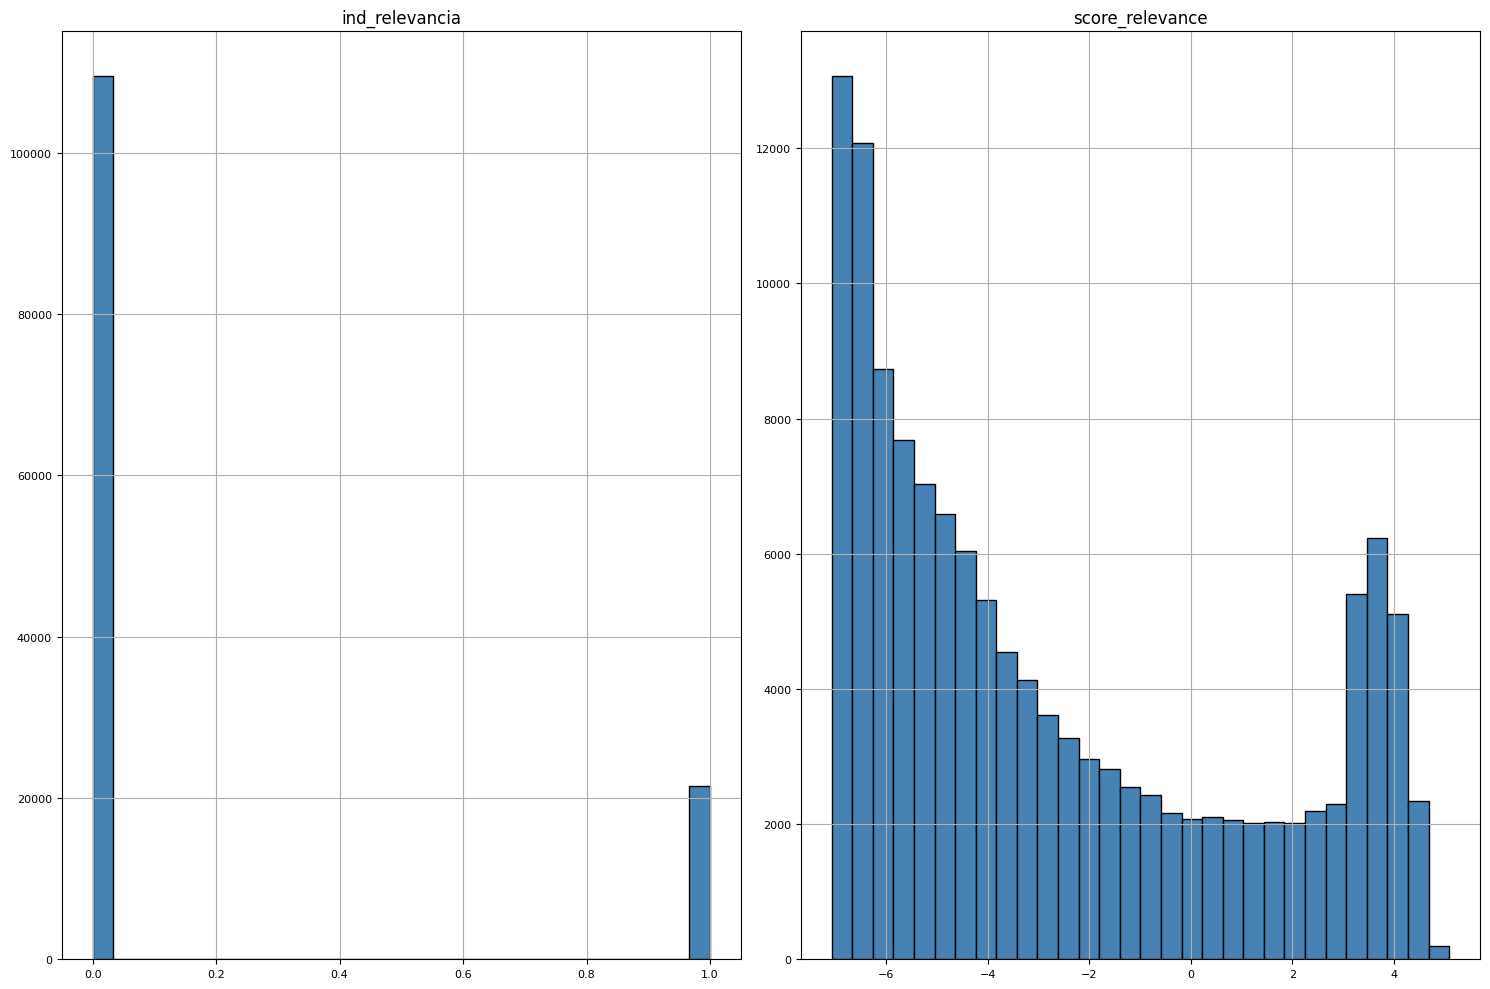

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.set_title('Histograma dos dados')
df_treino.hist(bins=30, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=True, ax=ax)  
plt.tight_layout() 

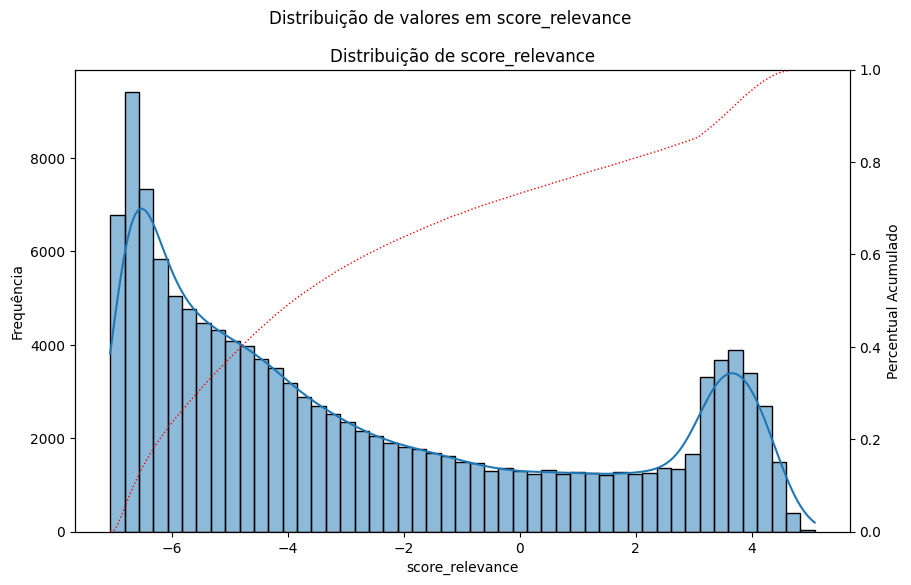

In [171]:
for coluna in ['score_relevance']:
    f, ax = plt.subplots(1, 1, figsize=(10,6))
    f.suptitle(f'Distribuição de valores em {coluna}')    
    # Plot o histograma normalizado com KDE
    sns.histplot(data=df_treino[coluna], kde=True, ax=ax, linewidth=1)

    # Calcula o percentual acumulado
    cumulative = df_treino[coluna].value_counts(normalize=True).sort_index().cumsum()

    # Cria um novo eixo y com o percentual acumulado
    ax2 = ax.twinx()
    ax2.plot(cumulative.index, cumulative.values, linestyle='dotted', marker='', color='red', linewidth=1)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Percentual Acumulado')

    # Configurações do gráfico
    ax.set_title(f'Distribuição de {coluna}')
    ax.set_xlabel(coluna)
    ax.set_ylabel('Frequência')
# Exibe o gráfico
plt.show()

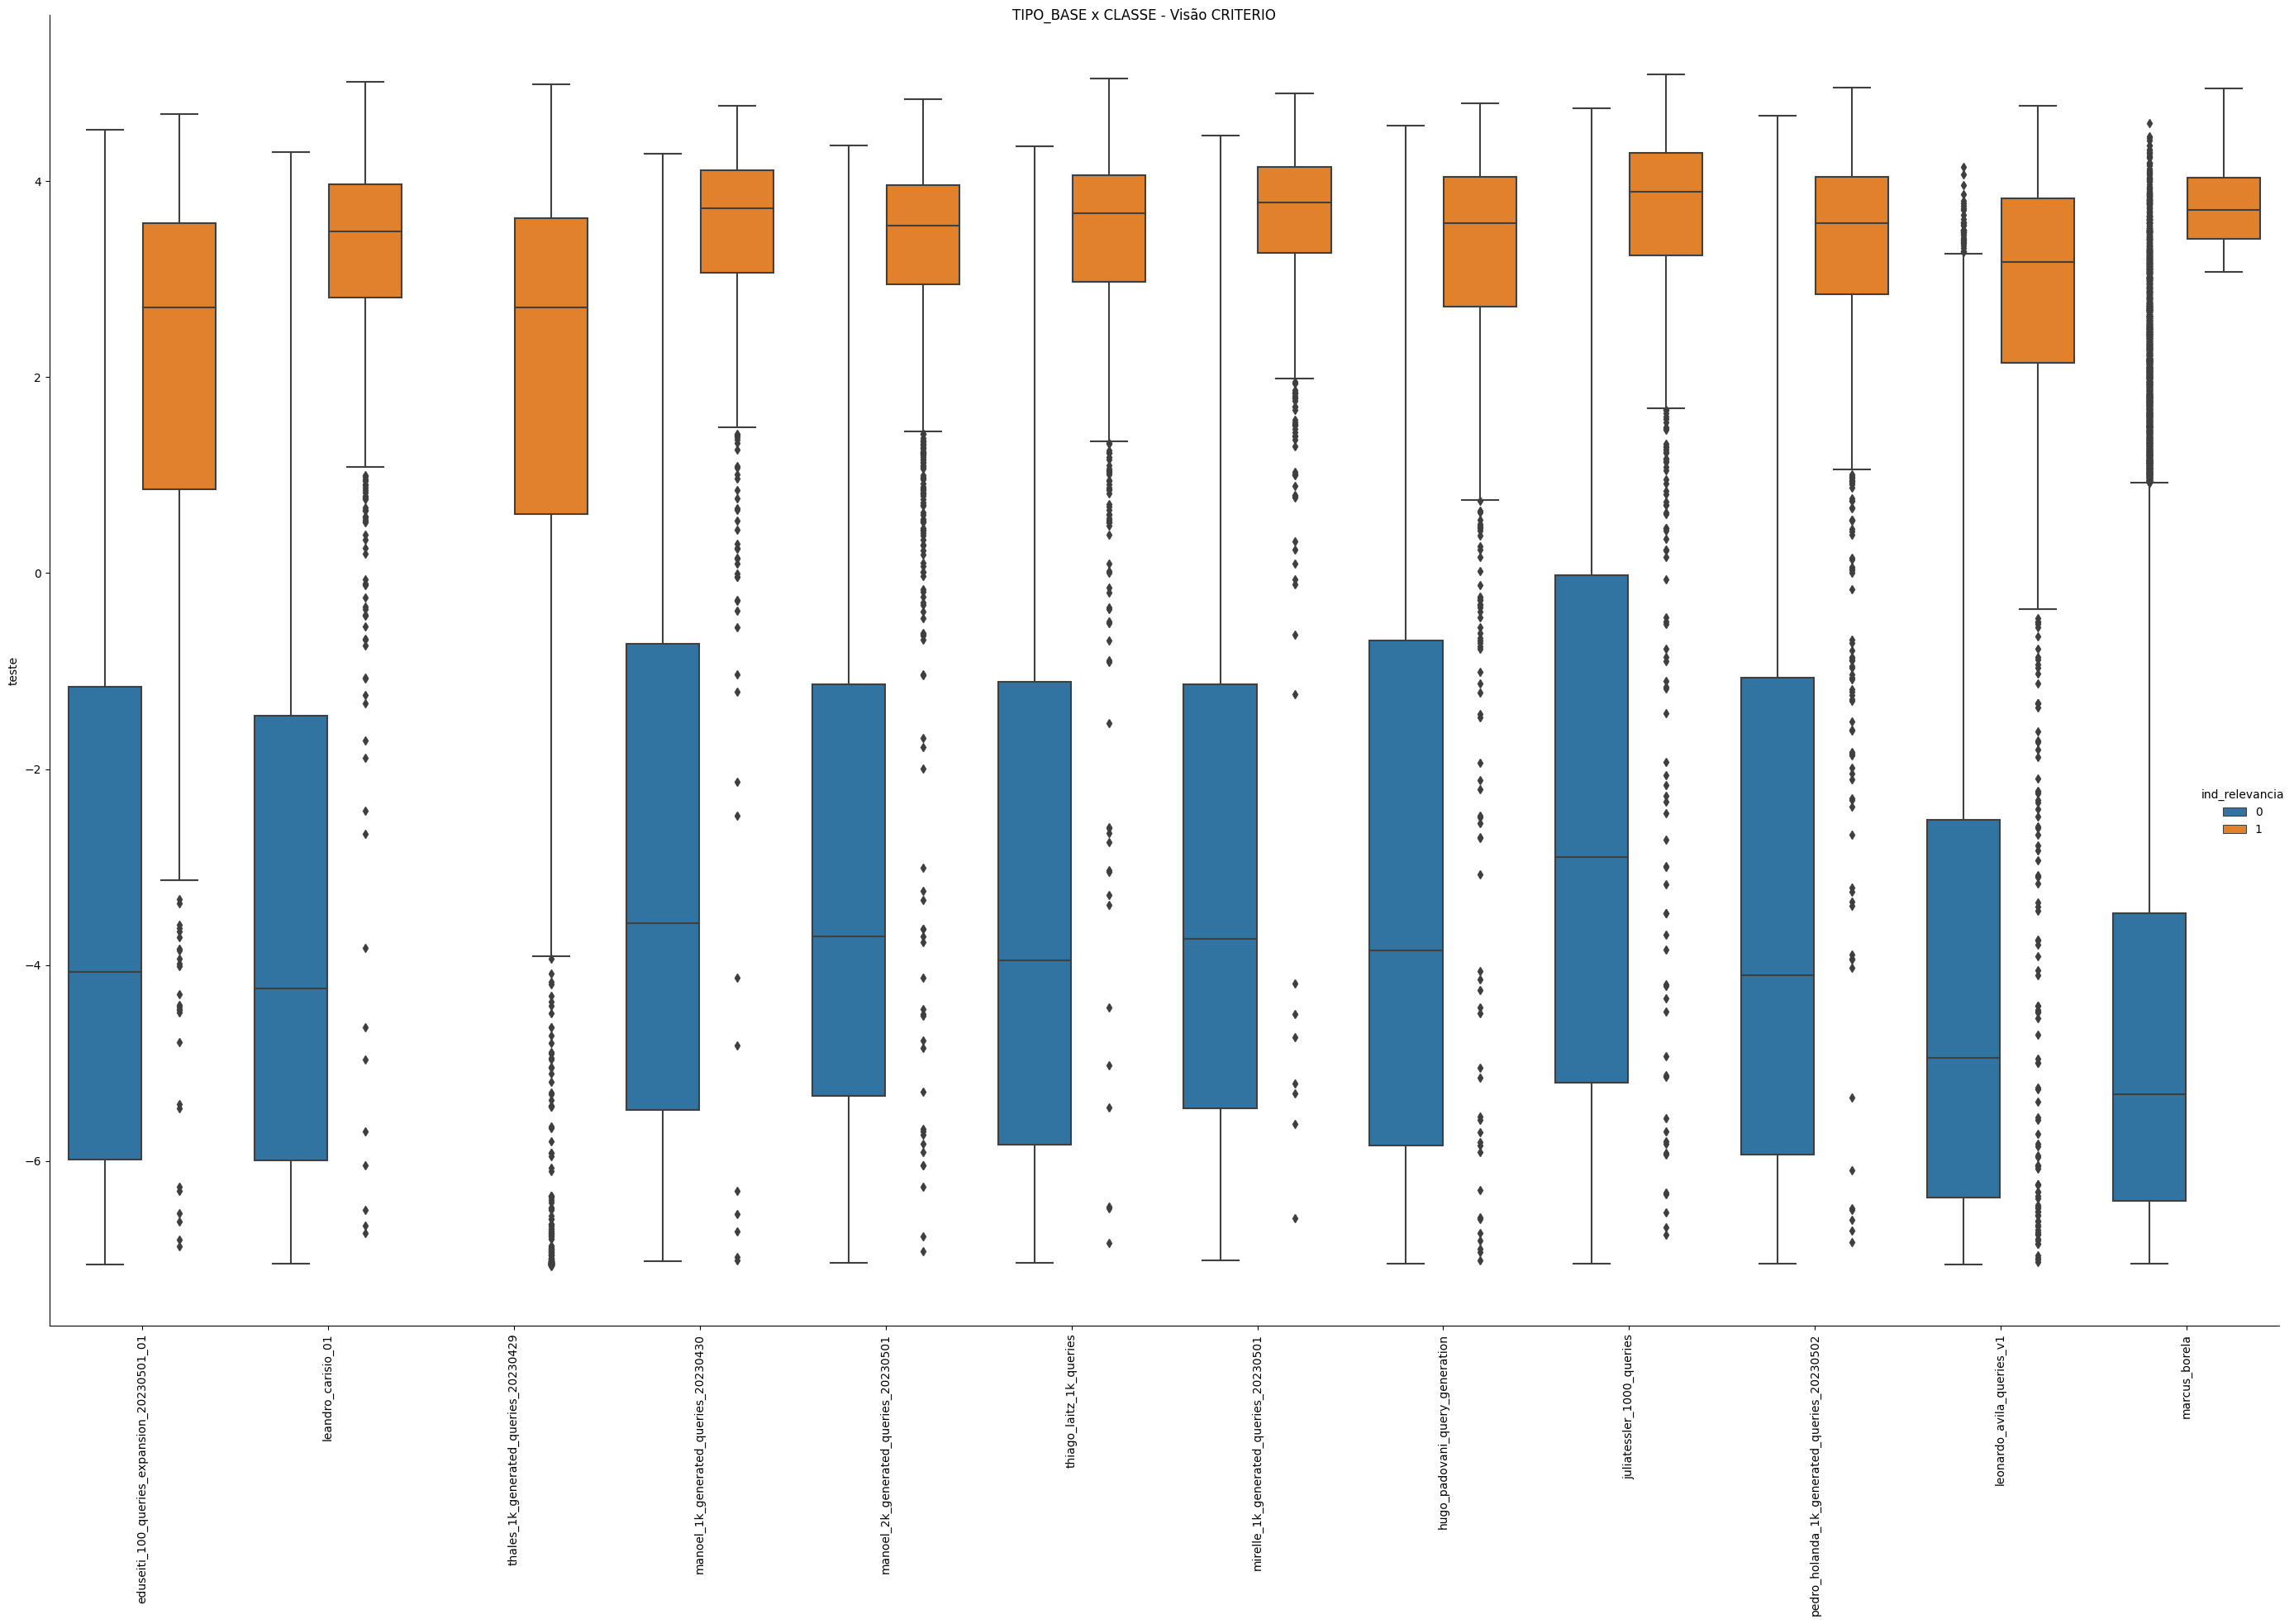

In [174]:
g = sns.catplot(x="origin", sharex=True, y="score_relevance", hue="ind_relevancia",
                kind="box", data=df_treino, height=20, aspect=20/15) # row="CLASSE", 
g.fig.suptitle('TIPO_BASE x CLASSE - Visão CRITERIO')
g.set_xticklabels(rotation=90)
g.set_axis_labels("", 'teste')
plt.tight_layout()
plt.show()

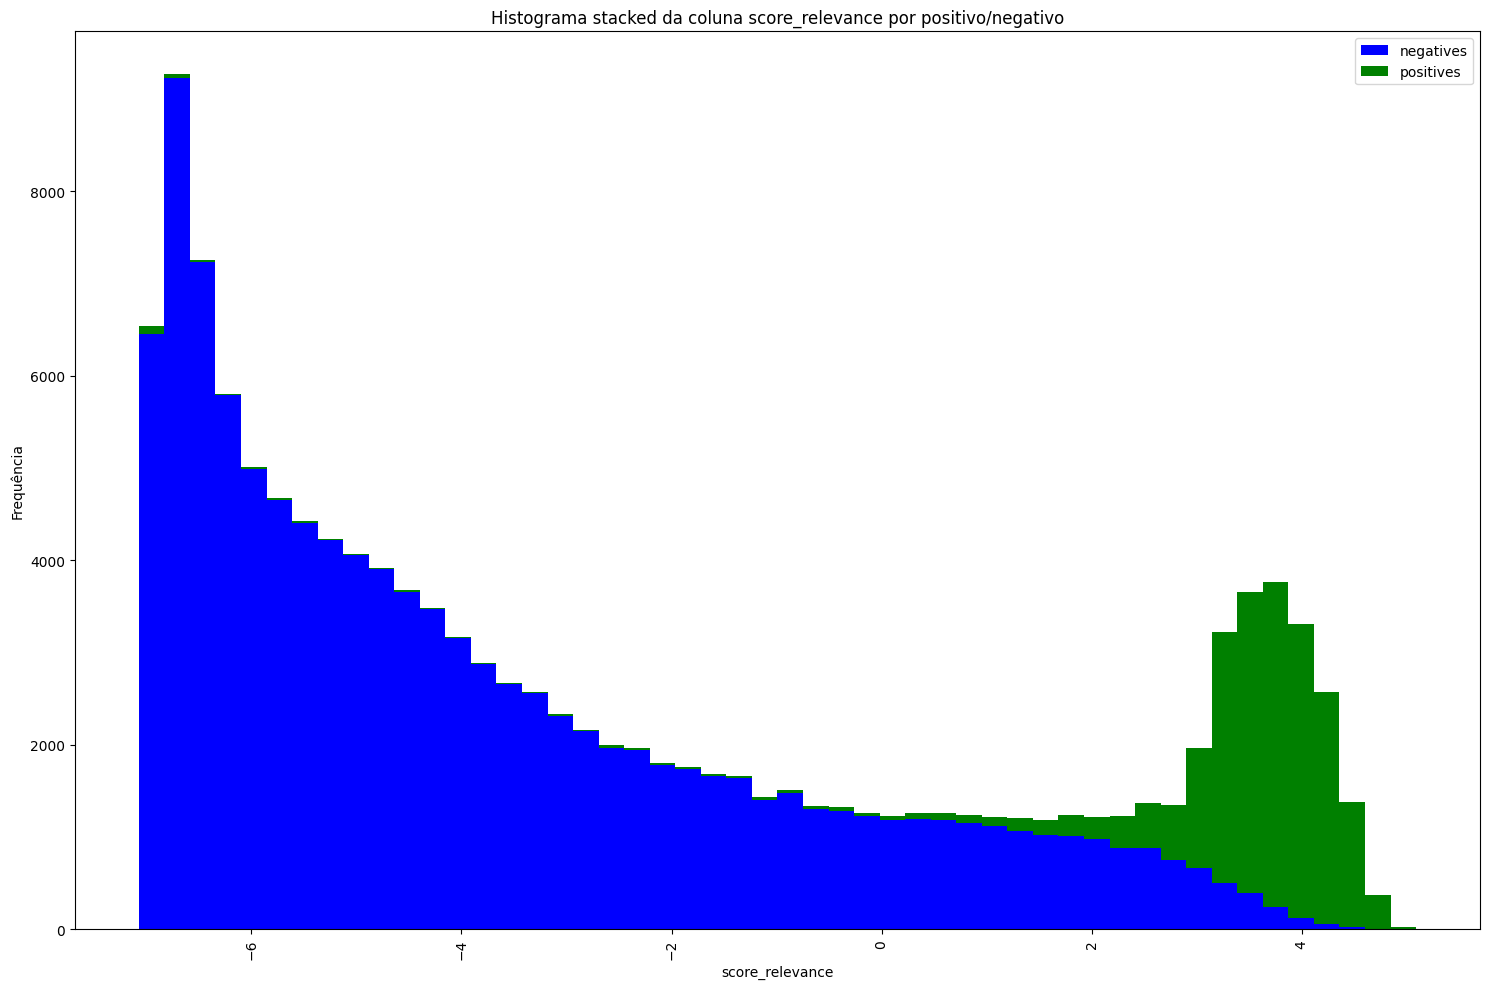

In [194]:
for coluna in ['score_relevance']:
    f, ax = plt.subplots(1, 1, figsize=(15,10))
    plt.hist([df_treino[df_treino['ind_relevancia']==0].sort_values(by=coluna)[coluna].dropna(), df_treino[df_treino['ind_relevancia']==1].sort_values(by=coluna)[coluna].dropna()], color=['blue', 'green'], label=['negatives', 'positives'], stacked=True, bins=50)

    
    plt.legend()
    plt.xlabel('score_relevance')
    plt.ylabel('Frequência')
    plt.title(f'Histograma stacked da coluna {coluna} por positivo/negativo')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [102]:
df_treino['ind_relevancia'].value_counts()

ind_relevancia
0    109575
1     21526
Name: count, Length: 2, dtype: int64

In [197]:
df_treino[(df_treino['score_relevance']>=1)]['ind_relevancia'].value_counts()

ind_relevancia
1    20537
0     9484
Name: count, Length: 2, dtype: int64

In [198]:
df_treino[(df_treino['score_relevance']<=-6)]['ind_relevancia'].value_counts()

ind_relevancia
0    30824
1      188
Name: count, Length: 2, dtype: int64

Critério: 
        
        negative: só deixar df_treino['score_relevance']<-6
        positive: só deixar df_treino['score_relevance']>1

        Obs.: bom que diminui a diferença entre os quantitativos nas classes

In [103]:
df_treino[(df_treino['score_relevance']<-6) & (df_treino['ind_relevancia']==0)].shape

(30824, 6)

In [104]:
df_treino[(df_treino['score_relevance']>=1) & (df_treino['ind_relevancia']==1)].shape

(20537, 6)

In [105]:
df_treino_filtrado = df_treino[(df_treino['score_relevance']<-6) & (df_treino['ind_relevancia']==0) | (df_treino['score_relevance']>=1) & (df_treino['ind_relevancia']==1)]

# Divisão em treino e validação (de forma estratificada)

In [106]:
df_treino_filtrado.head()

,origin,query,doc_id,ind_relevancia,doc_text,score_relevance
0,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,70hskj1o,1,Chatbots in the fight against the COVID-19 pan...,3.6176462
2,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,x7ol32mz,0,Prenatal Care Redesign: Creating Flexible Mate...,-6.8374410
3,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,b54dymlu,0,Impact of COVID-19 on maxillofacial surgery pr...,-6.3144741
4,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,h5vh6px7,0,Spine Surgical Procedures during Coronavirus D...,-6.2820787
6,eduseiti_100_queries_expansion_20230501_01,How can chatbots be designed to effectively sh...,eumithb4,0,Who shares? Profiling consumers in the sharing...,-6.4096088


In [107]:
from sklearn.model_selection import train_test_split

In [108]:
hparam['percent_test_size'] = .05 #@param [.10, .15, .20] {type:'raw'}

O dataset de validação será sempre no leiaute qp (para permitir comparar)

In [109]:
X_train, X_valid, Y_train, Y_valid = train_test_split(df_treino_filtrado[['query','doc_text']].values, 
                                                      df_treino_filtrado['ind_relevancia'].values,
                                                      test_size=hparam['percent_test_size'], 
                                                      stratify=df_treino_filtrado['ind_relevancia'].values, random_state=hparam['num_semente'])

In [110]:
X_train.shape

(48792, 2)

In [111]:
X_train.shape, type(X_valid), type(Y_valid), X_valid.shape, Y_valid.shape

((48792, 2), numpy.ndarray, numpy.ndarray, (2569, 2), (2569,))

In [112]:
print(np.unique(Y_train, return_counts=True), '\n', np.unique(Y_valid, return_counts=True))

(array([0, 1]), array([29282, 19510])) 
 (array([0, 1]), array([1542, 1027]))


In [113]:
X_train[0]

array(['What is the significance of neurologic complications related to nickel in cerebral aneurysm treatments?',
       'Nickel-Related Adverse Reactions in the Treatment of Cerebral Aneurysms: A Literature Review.. BACKGROUND Nickel is the most common metal allergen and predominantly affects women. It is also the ubiquitous component in the alloys used to manufacture intracranial devices for aneurysm treatments, including aneurysm clips, self-expanding stents, flow-diverting stents, and endosaccular occlusion devices. Adverse events related to nickel allergy after deployment of such devices are uncommon but can be severe, resulting in dilemmas in the choice of treatment strategies and devices in managing nickel-sensitive patients with intracranial aneurysms. METHODS A literature search was performed in accordance with the PRISMA guidelines to identify studies reporting on nickel-related adverse events in patients being treated for cerebral aneurysm. The materials of the culprit devic

In [114]:
Y_train[:4]

array([1, 0, 0, 0])

# Treinamento do ranqueador

Fonte: https://colab.research.google.com/drive/10etP7Lb915EC-uEuf1IKC8DYkyg_om6-?usp=sharing

In this notebook, we will finetuned and evaluate a BERT-based model on a document classification task.

Our dataset will be a smaller version of the IMDB Sentiment Analysis dataset.

To finetune and evaluate faster, we will be using [miniLM](https://huggingface.co/microsoft/MiniLM-L12-H384-uncased), which is small BERT-like model distilled from a larger one.

## Carga do modelo para finetuning (pré-treinado no MSMARCO)

"Começar treino do miniLM já treinado no MS MARCO":  cross-encoder/ms-marco-MiniLM-L-6-v2

In [119]:
# hparam['model_name'] = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
hparam['model_name'] = 'microsoft/MiniLM-L12-H384-uncased'
model = AutoModelForSequenceClassification.from_pretrained(hparam['model_name'], num_labels=2).to(hparam['device'])
tokenizer = AutoTokenizer.from_pretrained(hparam['model_name'])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [128]:
tokenizer = AutoTokenizer.from_pretrained(hparam['model_name'])

### Experimentações e computando limites

In [129]:
tokenizer.pad_token_id,tokenizer.cls_token_id,tokenizer.sep_token_id

(0, 101, 102)

In [130]:
x='x, it is just a test!'
y='y, it is just a continuation!'

In [131]:
print(tokenizer(x,y)['input_ids'])

[101, 1060, 1010, 2009, 2003, 2074, 1037, 3231, 999, 102, 1061, 1010, 2009, 2003, 2074, 1037, 13633, 999, 102]


In [132]:
print(tokenizer.encode_plus(x,y)['input_ids'])

[101, 1060, 1010, 2009, 2003, 2074, 1037, 3231, 999, 102, 1061, 1010, 2009, 2003, 2074, 1037, 13633, 999, 102]


In [133]:
model.config.max_position_embeddings

512

In [143]:
tokenizer.vocab_size

30522

## Definindo parâmetros e informações para o rastro (hparam) - sobre dados

In [120]:
X_train.shape[0] , X_valid.shape[0]

(48792, 2569)

In [146]:
# visto que "max_position_embeddings": 512 em https://huggingface.co/microsoft/MiniLM-L12-H384-uncased/blob/main/config.json
hparam['vocab_size'] = tokenizer.vocab_size
hparam['batch_size'] = 32
hparam['num_epochs'] = 8  
hparam['num_sentenca_train'] = X_train.shape[0] # ou 37400
hparam['num_sentenca_valid'] = X_valid.shape[0] # 


## Carregando o Dataset e os Dataloaders


In [142]:
datasets_carregados_previamente = True #@param {type:"boolean"}

print(datasets_carregados_previamente)

False


In [ ]:
if datasets_carregados_previamente:
  with open(f"{DIRETORIO_TREINO}/dataset_train_{hparam['num_sentenca_train']}.pt",'rb') as f:
    buffer = io.BytesIO(f.read())
  dataset_valid = torch.load(buffer)
  with open(f"{DIRETORIO_TREINO}/dataset_valid_{hparam['num_sentenca_valid']}.pt"','rb') as f:
    buffer = io.BytesIO(f.read())
  data_loader = torch.load(buffer)
  print('Datasets carregados')   

Datasets carregados


In [141]:
%%time
if not datasets_carregados_previamente:
    print("carregando valid_dataset")  
    dataset_valid = MyDataset(texts=X_valid, classes=Y_valid, tokenizer=tokenizer)
    torch.save(dataset_train, f"{DIRETORIO_TREINO}/dataset_valid_{hparam['num_sentenca_valid']}.pt")

carregando valid_dataset


encoding text pair: 100%|██████████| 2569/2569 [00:03<00:00, 845.56it/s]


	Vou converter lista para tensor;  Momento: [2023-May-02 23:00:37]
CPU times: user 3.27 s, sys: 308 ms, total: 3.58 s
Wall time: 3.57 s


In [138]:
%%time
if not datasets_carregados_previamente:
    print("carregando train_dataset")  
    dataset_train = MyDataset(texts=X_train, classes=Y_train, tokenizer=tokenizer)
    torch.save(dataset_train, f"{DIRETORIO_TREINO}/dataset_train_{hparam['num_sentenca_train']}.pt")

carregando train_dataset


encoding text pair: 100%|██████████| 48792/48792 [01:00<00:00, 807.79it/s]


	Vou converter lista para tensor;  Momento: [2023-May-02 22:59:01]
CPU times: user 1min, sys: 164 ms, total: 1min
Wall time: 1min


In [145]:
dataloader_train = DataLoader(dataset_train, batch_size=hparam['batch_size'], shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=hparam['batch_size'], shuffle=False)

## Funções auxiliares de treinamento

In [162]:
def treina_modelo (model, hparam, parm_dataloader_train, parm_dataloader_valid, parm_se_salva_modelo:bool=True, parm_se_gera_rastro:bool=True):
    global DIRETORIO_TREINO, tag_contexto_rastro

    if parm_se_gera_rastro:
        rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag= tag_contexto_rastro)

    history = []
    n_examples = 0
    time_inicio_treino = time.time()

    try:
        best_metrica_validacao = 0 # float('-inf')
        best_epoch = 0
        

        for epoch in tqdm(range(hparam['num_epochs']), desc='Epochs'):
            model.train()

            train_losses = []
            correct = 0
            for batch in tqdm(parm_dataloader_train, mininterval=0.5, desc='Train', disable=False):
                # parm_model(**BatchEncoding(batch).to(hparam['device']))
                outputs = model(input_ids=batch['input_ids'].to(hparam['device']),
                                attention_mask=batch['attention_mask'].to(hparam['device']), 
                                token_type_ids=batch['token_type_ids'].to(hparam['device']), 
                                labels=batch['labels'].to(hparam['device']))
                loss = outputs.loss
                loss.backward()
                hparam['optimizer'].step()
                hparam['scheduler'].step()
                hparam['optimizer'].zero_grad()
                n_examples += len(batch['input_ids'])  # Increment of batch size
                train_losses.append(loss.cpu().item())

                preds = outputs.logits.argmax(dim=1)
                correct += (preds == batch['labels'].to(hparam['device'])).sum().item()    

            if isinstance(parm_dataloader_train,torch.utils.data.dataloader.DataLoader): 
                accuracy_train = correct / len(parm_dataloader_train.dataset)
            elif isinstance(parm_dataloader_train,list):  # usado para overfit em um batch
                accuracy_train = correct / len(parm_dataloader_train[0]['labels'])    
                assert len(parm_dataloader_train) == 1, f"Calculo de accuracy para overfit em um batch precisa ser revisado"

            loss_train_mean = mean(train_losses)

            accuracy_valid, mean_loss_valid = evaluate(model=model, dataloader=parm_dataloader_valid, set_name='Valid')

            
            print(f'Epoch: {epoch + 1} Training loss: {loss_train_mean:0.2f} accuracy: {accuracy_train:0.3f} Em validação: loss: {mean_loss_valid:0.3f}; accuracy: {accuracy_valid:0.3f}')
            metrica_rastro = {"train/loss": loss_train_mean, 
                            "train/accuracy": accuracy_train, 
                            "train/n_examples": n_examples, 
                            "train/learning_rate": hparam["optimizer"].param_groups[0]["lr"],
                            "valid/loss": mean_loss_valid,
                            "valid/accuracy": accuracy_valid}  
            history.append(metrica_rastro)
            if parm_se_gera_rastro:   
                rastro_neptune.salva_metrica(metrica_rastro)


            if accuracy_valid > best_metrica_validacao:
                best_model_dict = model.state_dict()
                best_metrica_validacao = accuracy_valid
                best_epoch = epoch + 1
                # print(f'encontrado best model Epoch: {epoch + 1} ')
            elif hparam['early_stop'] < (epoch + 1 - best_epoch):
                print(f"Parando por critério de early_stop na época {epoch + 1} sendo best_epoch {best_epoch} e ealy_stop {hparam['early_stop']}")
                break # for epoch


        if parm_se_salva_modelo:
            model.load_state_dict(best_model_dict)
            model.to(hparam['device'])
            path_modelo = f'{DIRETORIO_TREINO}/model_fim_treino_{time.strftime("%Y-%b-%d %H:%M:%S")}.pt'
            # torch.save(model, path_modelo) 
            model.save_pretrained(path_modelo)   
            print(f"Modelo com melhor resultado em validação (epoch {best_epoch}) salvo após treino em {path_modelo}")

        # calculando tempo gasto e médio por 
        tempo_treino = time.time() - time_inicio_treino   
        if parm_se_gera_rastro:
            rastro_neptune.run_neptune["context/tempo_treino"] = tempo_treino
            rastro_neptune.run_neptune["context/best_epoch"] = best_epoch
            rastro_neptune.run_neptune["context/tempo_treino_epoc_mean"] = tempo_treino/hparam['num_epochs']
            # rastro_neptune.gera_grafico_modelo(parm_dataloader_train, model)  

    finally: # para não deixar em aberto a execução no Neptune
        if parm_se_gera_rastro:
            rastro_neptune.stop()
  
    return {"loss_validacao":mean_loss_valid, "loss_treino":loss_train_mean, "best_metrica_validacao":best_metrica_validacao,  "best_epoch": best_epoch, "history": history}


In [149]:
def count_parameters(model):
    """
    Conta o número de parâmetros treináveis em um modelo PyTorch.

    Args:
        model (torch.nn.Module): O modelo PyTorch a ser avaliado.

    Returns:
        int: O número de parâmetros treináveis do modelo.

    """
    # Retorna a soma do número de elementos em cada tensor de parâmetro que requer gradiente.
    # A propriedade "requires_grad" é definida como True para todos os tensores de parâmetro que 
    # precisam ser treinados, enquanto que para aqueles que não precisam, ela é definida como False.
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [150]:
# We first define the evaluation function to measure accuracy and loss
def evaluate(model, dataloader, set_name):
    losses = []
    correct = 0
    model.eval()
    with torch.no_grad():
        for ndx, batch in tqdm(enumerate(dataloader), mininterval=0.5, desc=set_name, disable=False):
            input_ids = batch['input_ids'].to(hparam['device'])
            token_type_ids = batch['token_type_ids'].to(hparam['device'])
            attention_mask = batch['attention_mask'].to(hparam['device'])                                              
            labels = batch['labels'].to(hparam['device'])                                              
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            loss_val = outputs.loss
            losses.append(loss_val.cpu().item())
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
    if isinstance(dataloader,torch.utils.data.dataloader.DataLoader): 
        accuracy = correct / len(dataloader.dataset)
    elif isinstance(dataloader,list):  # usado para overfit em um batch
        accuracy = correct / len(dataloader[0]['labels'])
        assert len(dataloader) == 1, f"Calculo de accuracy para overfit em um batch precisa ser revisado"
    mean_loss = mean(losses)
    return accuracy, mean_loss

In [151]:
from torch import nn
from torch import optim
from tqdm.auto import tqdm
from transformers import get_linear_schedule_with_warmup

In [156]:
def inicializa_modelo():
  global model, hparam

  model = AutoModelForSequenceClassification.from_pretrained(hparam['model_name'], num_labels=2).to(hparam['device'])
  hparam['learning_rate']=1e-3# 3e-5 # 1e-3
  hparam['num_params'] = count_parameters(model)
  # print(f"Number of model parameters: {hparam['num_params']}")
  hparam['amsgrad']=False
  hparam['weight_decay'] = 1e-4
  hparam['early_stop'] = 5
  hparam['num_training_steps'] = hparam['num_epochs'] * len(dataloader_train)
  hparam['num_warmup_steps'] = int(hparam['num_training_steps'] * 0.1)
  hparam['optimizer'] = torch.optim.Adam(model.parameters(), lr=hparam['learning_rate'], weight_decay= hparam['weight_decay'], amsgrad=hparam['amsgrad'])
  hparam['scheduler'] = get_linear_schedule_with_warmup(hparam['optimizer'], hparam['num_warmup_steps'], hparam['num_training_steps'])  



In [157]:
inicializa_modelo()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [158]:
hparam

{'num_workers_dataloader': 0,
 'device': device(type='cuda', index=0),
 'num_semente': 13,
 'percent_test_size': 0.05,
 'model_name': 'microsoft/MiniLM-L12-H384-uncased',
 'vocab_size': 30522,
 'batch_size': 32,
 'num_epochs': 8,
 'num_sentenca_train': 48792,
 'num_sentenca_valid': 2569,
 'learning_rate': 0.001,
 'num_params': 33360770,
 'amsgrad': False,
 'weight_decay': 0.0001,
 'early_stop': 5,
 'num_training_steps': 12200,
 'num_warmup_steps': 1220,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.001
     lr: 0.0
     maximize: False
     weight_decay: 0.0001
 ),
 'scheduler': <torch.optim.lr_scheduler.LambdaLR at 0x7fe301193a00>}

### Evaluating on the valid dataset before training

In [159]:
accuracy, mean_loss = evaluate(model=model, dataloader=dataloader_valid, set_name='Valid')
print(f'Em validação: loss: {mean_loss:0.3f}; accuracy: {accuracy:0.3f}')

Valid: 81it [00:09,  8.61it/s]

Em validação: loss: 0.693; accuracy: 0.600


### Testando em poucos dados: um batch apenas. Esperado overfit loss próxima de zero.

Por algum motivo a investigar quando passo dataset como lista não está gerando aprendizado. Mas quando passo normal, o modelo está aprendendo. 




In [160]:
hparam['num_epochs'] = 5
hparam['early_stop'] = 1

In [163]:
resultado =  treina_modelo (model, hparam,  [next(iter(dataloader_train))], [next(iter(dataloader_valid))], parm_se_salva_modelo=False, parm_se_gera_rastro=False)

Train: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
Valid: 1it [00:00,  8.66it/s]
Epochs:  20%|██        | 1/5 [00:00<00:03,  1.32it/s]

Epoch: 1 Training loss: 0.69 accuracy: 0.469 Em validação: loss: 0.694; accuracy: 0.438


Train: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
Valid: 1it [00:00,  8.69it/s]
Epochs:  40%|████      | 2/5 [00:01<00:02,  1.37it/s]

Epoch: 2 Training loss: 0.69 accuracy: 0.531 Em validação: loss: 0.694; accuracy: 0.438


Train: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
Valid: 1it [00:00,  8.72it/s]
Epochs:  40%|████      | 2/5 [00:02<00:03,  1.09s/it]

Epoch: 3 Training loss: 0.69 accuracy: 0.531 Em validação: loss: 0.694; accuracy: 0.438
Parando por critério de early_stop na época 3 sendo best_epoch 1 e ealy_stop 1


In [164]:
inicializa_modelo()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [165]:
mostra_memoria(['cpu', 'gpu'])

Your runtime RAM in gb: 
 total 67.35
 available 40.78
 used 25.34
 free 37.92
 cached 3.95
 buffers 0.14
/nGPU
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue May  2 23:09:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+===================

### Treino do conjunto completo para leiaute_input = 'qp'

In [167]:
hparam['num_epochs'] = 15
hparam['early_stop'] = 5

In [168]:
history = treina_modelo (model, hparam,  dataloader_train, dataloader_valid)

/tmp/ipykernel_238969/1999415923.py:12: NeptuneDeprecationWarning: `init` is deprecated, use `init_run` instead. We'll end support of it in `neptune-client==1.0.0`. For details, see https://docs.neptune.ai/setup/neptune-client_1-0_release_changes
  self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/tmp/ipykernel_238969/1999415923.py:26: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` or `repr(object)` instead. For details, see https://docs.neptune.ai/setup/neptune-client_1-0_release_changes
  self.run_neptune['parameters'] = vparams
Train: 100%|██████████| 1525/1525 [15:07<00:00,  1.68it/s]
Valid: 81it [00:09,  8.45it/s]
Epochs:   7%|▋         | 1/15 [15:16<3:33:54, 916.73s/it]

Epoch: 1 Training loss: 0.65 accuracy: 0.619 Em validação: loss: 0.673; accuracy: 0.600


Train: 100%|██████████| 1525/1525 [15:07<00:00,  1.68it/s]
Valid: 81it [00:09,  8.31it/s]
Epochs:  13%|█▎        | 2/15 [30:33<3:18:40, 916.97s/it]

Epoch: 2 Training loss: 0.67 accuracy: 0.600 Em validação: loss: 0.674; accuracy: 0.600


In [ ]:
history